In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

os.environ['CUDA_VISIBLE_DEVICES']='1'
tf.config.set_soft_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
GPU is available


# Constants

In [2]:
folder_name = '20210904_en_NLG'
wv_dim = 32
que_pad = 300
num_words = 10000

# Load data

In [3]:
(text_train, class_train), (text_vali, class_vali) = imdb.load_data(
    num_words = num_words-2,
)
text_vali = text_vali[:2500]
print(len(text_train))
print(len(text_vali))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


25000
2500


/home/ai-lab/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/ai-lab/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


# Add BOS and EOS

In [4]:
# Index num_words -2 = BOS
# Index num_words -1 = EOS
null = [s.insert(0,num_words-2) for s in text_train]
null = [s.append(num_words-1) for s in text_train]
null = [s.insert(0,num_words-2) for s in text_vali]
null = [s.append(num_words-1) for s in text_vali]

# Padding

In [5]:
# Data padding for training
decoder_train = sequence.pad_sequences(
    text_train,
    maxlen = que_pad,
    padding = 'post',
)
teacher_train = decoder_train[:,1:]
teacher_train = sequence.pad_sequences(
    teacher_train,
    maxlen = que_pad,
    padding = 'post',
)
# Data padding for valiation
decoder_vali = sequence.pad_sequences(
    text_vali,
    maxlen = que_pad,
    padding = 'post',
)
teacher_vali = decoder_vali[:,1:]
teacher_vali = sequence.pad_sequences(
    teacher_vali,
    maxlen = que_pad,
    padding = 'post',
)
print(f'decoder_train shape:{decoder_train.shape}')
print(f'teacher_train shape:{teacher_train.shape}')
print(f'decoder_vali shape:{decoder_vali.shape}')
print(f'teacher_vali shape:{teacher_vali.shape}')


decoder_train shape:(25000, 300)
teacher_train shape:(25000, 300)
decoder_vali shape:(2500, 300)
teacher_vali shape:(2500, 300)


In [6]:
print(decoder_train[:1])
print(teacher_train[:1])

[[9998    1   14   22   16   43  530  973 1622 1385   65  458 4468   66
  3941    4  173   36  256    5   25  100   43  838  112   50  670    2
     9   35  480  284    5  150    4  172  112  167    2  336  385   39
     4  172 4536 1111   17  546   38   13  447    4  192   50   16    6
   147 2025   19   14   22    4 1920 4613  469    4   22   71   87   12
    16   43  530   38   76   15   13 1247    4   22   17  515   17   12
    16  626   18    2    5   62  386   12    8  316    8  106    5    4
  2223 5244   16  480   66 3785   33    4  130   12   16   38  619    5
    25  124   51   36  135   48   25 1415   33    6   22   12  215   28
    77   52    5   14  407   16   82    2    8    4  107  117 5952   15
   256    4    2    7 3766    5  723   36   71   43  530  476   26  400
   317   46    7    4    2 1029   13  104   88    4  381   15  297   98
    32 2071   56   26  141    6  194 7486   18    4  226   22   21  134
   476   26  480    5  144   30 5535   18   51   36   28  224   

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [7]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Test positional encoding

(1, 10, 64)


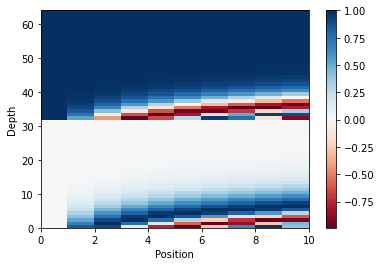

In [8]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Embedding

In [9]:
def getEmb():
    initializer = tf.keras.initializers.GlorotNormal()
    mask_embedding = initializer(shape=(1, wv_dim)).numpy()
    emb = Embedding(
        num_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(que_pad)),
        trainable = True,
    )
    return emb

# Generator

[OneHot relaxation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical)
based on [Jang+16](https://arxiv.org/abs/1611.01144) and [Maddison+16](https://arxiv.org/abs/1611.00712) 
<br>
[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [10]:
def Transformer(que_pad, wv_dim, mask = None, rate = 0.1):
    # Inputs
    mem  = Input((que_pad, wv_dim))
    # Constants
    ff_dim = wv_dim*16
    # Multi-Head Attention
    # TODO: concatenation
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(mem)
    v = Dense(wv_dim)(mem)
    #print(mask)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask,
    )
    #mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    #ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        mem,
        [mem_new, out]
    )
    return model

# GPT downstream
def getGPT(emb):
    _input = Input((que_pad,))
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    mask = np.tri(que_pad, que_pad, 0) # (q_dim, k_dim)
    # forward sentence
    for i in range(1):
        tLayer = Transformer(que_pad, wv_dim, mask)
        mem, output = tLayer((mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        _input, 
        output,
        name = 'GPT'
    ) 
    return model

In [11]:
emb = getEmb()
mleG=getGPT(emb)
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "GPT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 32)           320000    
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 300, 32)           0         
_________________________________________________________________
layer_normalization (LayerNo (None, 300, 32)           64        
_________________________________________________________________
model (Functional)           [(None, 300, 32), (None,  53408     
_________________________________________________________________
activation (Activation)      (None, 300, 32)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 300, 10000)        330000  

In [12]:
mleG.fit(
    decoder_train, 
    teacher_train, 
    batch_size=32, 
    epochs=300, 
    shuffle=True, 
    validation_data = (decoder_vali, teacher_vali), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
782/782 [==============================] - 39s 47ms/step - loss: 4.7933 - accuracy: 0.3820 - val_loss: 3.8223 - val_accuracy: 0.4282
Epoch 2/300
782/782 [==============================] - 37s 47ms/step - loss: 3.7700 - accuracy: 0.4324 - val_loss: 3.5330 - val_accuracy: 0.4581
Epoch 3/300
782/782 [==============================] - 37s 47ms/step - loss: 3.5552 - accuracy: 0.4497 - val_loss: 3.4251 - val_accuracy: 0.4653
Epoch 4/300
782/782 [==============================] - 37s 47ms/step - loss: 3.4741 - accuracy: 0.4548 - val_loss: 3.3694 - val_accuracy: 0.4688
Epoch 5/300
782/782 [==============================] - 37s 47ms/step - loss: 3.4126 - accuracy: 0.4590 - val_loss: 3.3181 - val_accuracy: 0.4731
Epoch 6/300
782/782 [==============================] - 37s 47ms/step - loss: 3.3629 - accuracy: 0.4626 - val_loss: 3.2863 - val_accuracy: 0.4759
Epoch 7/300
782/782 [==============================] - 37s 47ms/step - loss: 3.3275 - accuracy: 0.4652 - val_loss: 3.2622 - val_ac

782/782 [==============================] - 37s 47ms/step - loss: 3.1131 - accuracy: 0.4821 - val_loss: 3.1406 - val_accuracy: 0.4897
Epoch 58/300
782/782 [==============================] - 37s 47ms/step - loss: 3.1123 - accuracy: 0.4822 - val_loss: 3.1411 - val_accuracy: 0.4897
Epoch 59/300
782/782 [==============================] - 37s 47ms/step - loss: 3.1116 - accuracy: 0.4823 - val_loss: 3.1404 - val_accuracy: 0.4896
Epoch 60/300
782/782 [==============================] - 37s 47ms/step - loss: 3.1109 - accuracy: 0.4823 - val_loss: 3.1393 - val_accuracy: 0.4896
Epoch 61/300
782/782 [==============================] - 37s 47ms/step - loss: 3.1103 - accuracy: 0.4824 - val_loss: 3.1387 - val_accuracy: 0.4894
Epoch 62/300
782/782 [==============================] - 37s 48ms/step - loss: 3.1097 - accuracy: 0.4824 - val_loss: 3.1400 - val_accuracy: 0.4897
Epoch 63/300
782/782 [==============================] - 37s 47ms/step - loss: 3.1091 - accuracy: 0.4825 - val_loss: 3.1419 - val_accuracy

In [13]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss = mleG.evaluate(decoder_vali, teacher_vali)
print(loss)

79/79 [==============================] - 2s 32ms/step - loss: 3.1381 - accuracy: 0.4898
[3.1381313800811768, 0.48980000615119934]


No handles with labels found to put in legend.


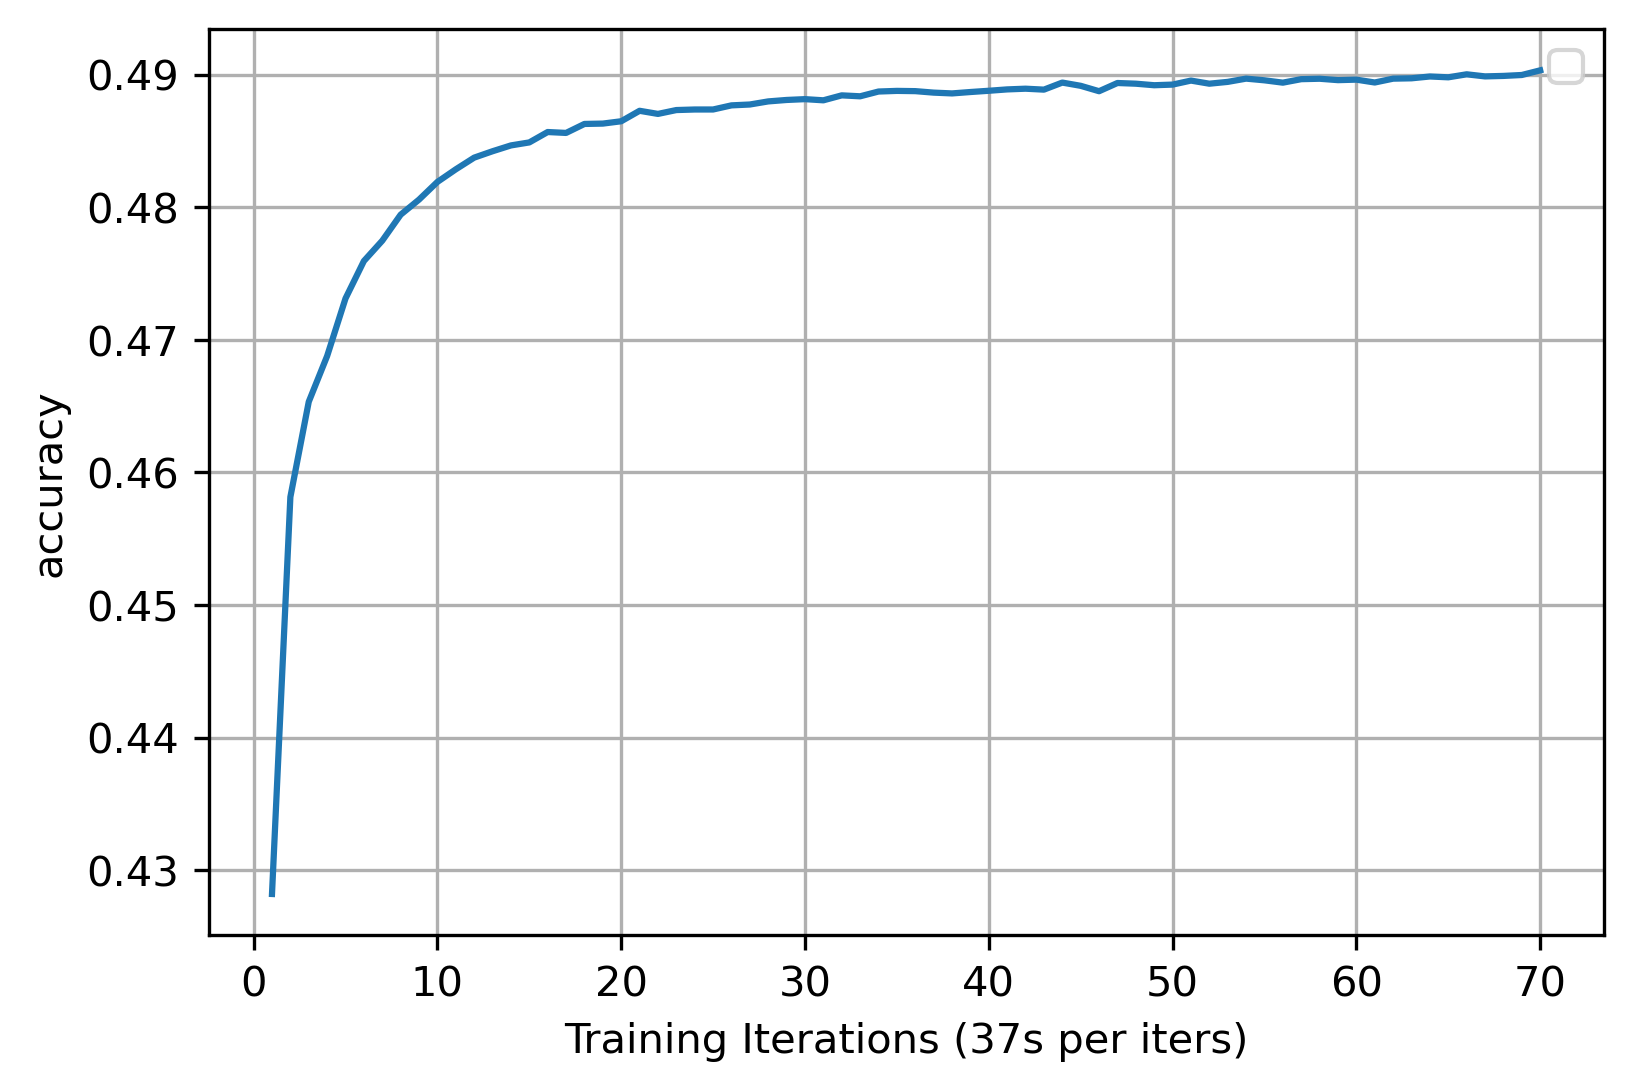

In [5]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/mleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-2]))
plt.figure(dpi = 300)
plt.plot(np.arange(1,len(nll_mle)+1), nll_mle)
plt.grid(True)
plt.ylabel(r'accuracy')
plt.xlabel('Training Iterations (37s per iters)')
plt.legend()
plt.show()

In [17]:
np.savetxt(f'{folder_name}/mleG_nll_list.txt', nll_mle)